<a href="https://colab.research.google.com/github/diogopaz/projeto-marvel/blob/CreatorsDatabaseBrch/projeto_marvel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas necessárias

In [ ]:
!pip install dotenv --quiet
!pip install plotly --quiet

In [ ]:
import requests
import hashlib
import time
import os
import pandas as pd
from dotenv import load_dotenv
import sqlite3
from google.colab import userdata
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Carregando variáveis de ambiente
Estamos fazendo upload do arquivo .env com as chaves de acesso à API no ambeinte de execução do colab.

In [ ]:
load_dotenv(dotenv_path='/content/.env')
public_key = userdata.get('MARVEL_PUBLIC_KEY') or os.getenv('MARVEL_PUBLIC_KEY')
private_key = userdata.get('MARVEL_PRIVATE_KEY') or os.getenv('MARVEL_PRIVATE_KEY')

# Montando os parâmetros para realizar a requisição

In [ ]:
def get_auth_params():
    ts = str(time.time())
    to_hash = ts + private_key + public_key
    hash_md5 = hashlib.md5(to_hash.encode()).hexdigest()
    return {
        'ts': ts,
        'apikey': public_key,
        'hash': hash_md5
    }

In [ ]:
def req(endpoint, limit, offset = 0):
  params = get_auth_params()
  params.update({
      'limit': limit,
      'offset': offset
  })
  response = requests.get(f'https://gateway.marvel.com/v1/public/{endpoint}', params=params)
  data = response.json()
  return data
req('characters',10)


{'code': 200,
 'status': 'Ok',
 'copyright': '© 2025 MARVEL',
 'attributionText': 'Data provided by Marvel. © 2025 MARVEL',
 'attributionHTML': '<a href="http://marvel.com">Data provided by Marvel. © 2025 MARVEL</a>',
 'etag': '44935a74aed4cd8f431adbf37ceb5d7e95bd924f',
 'data': {'offset': 0,
  'limit': 10,
  'total': 1564,
  'count': 10,
  'results': [{'id': 1011334,
    'name': '3-D Man',
    'description': '',
    'modified': '2014-04-29T14:18:17+0000',
    'thumbnail': {'path': 'http://i.annihil.us/u/prod/marvel/i/mg/c/e0/535fecbbb9784',
     'extension': 'jpg'},
    'resourceURI': 'https://gateway.marvel.com/v1/public/characters/1011334',
    'comics': {'available': 12,
     'collectionURI': 'https://gateway.marvel.com/v1/public/characters/1011334/comics',
     'items': [{'resourceURI': 'https://gateway.marvel.com/v1/public/comics/24571',
       'name': 'Avengers: The Initiative (2007) #14'},
      {'resourceURI': 'https://gateway.marvel.com/v1/public/comics/21366',
       'name':

# Criação da tabelas no sqlite

### Tabela characters

In [ ]:
# Conectando ao bd sqlite
conn = sqlite3.connect('marvel.db')
cursor = conn.cursor()

# Criando tabela characters
cursor.execute('''
CREATE TABLE IF NOT EXISTS characters (
    id INTEGER PRIMARY KEY,
    name TEXT,
    description TEXT,
    modified TEXT,
    comics_available INTEGER
)
''')

conn.commit()

# Salvando o personagem no banco
def save_character(char):
    comics_available = char.get('comics', {}).get('available', 0)

    cursor.execute('''
    INSERT OR REPLACE INTO characters (id, name, description, modified, comics_available)
    VALUES (?, ?, ?, ?, ?)
    ''', (
        char['id'],
        char['name'],
        char.get('description', ''),
        char.get('modified', ''),
        comics_available
    ))

    conn.commit()

# Baixando e salvando todos os personagens
def fetch_and_save_characters():
    limit = 100
    offset = 0
    total = 1
    count = 0

    while offset < total:
        print(f'Buscando personagens... offset={offset}')
        params = get_auth_params()
        params.update({
            'limit': limit,
            'offset': offset
        })

        response = requests.get('https://gateway.marvel.com/v1/public/characters', params=params)

        if response.status_code != 200:
            print(f'Erro na requisição: {response.status_code}')
            break

        data = response.json()['data']
        total = data['total']
        results = data['results']

        for char in results:
            save_character(char)
            count += 1

        offset += limit
        time.sleep(0.1)

    print(f'Sucesso! {count} personagens salvos no banco')

In [ ]:
# >>> Executa
fetch_and_save_characters()

# >>> Fecha conexão
conn.close()

In [ ]:
conn = sqlite3.connect('marvel.db')
cursor = conn.cursor()
cursor.execute('select * from characters')
charr = cursor.fetchall()
df_char = pd.DataFrame(charr, columns=['id', 'name', 'description', 'modified', 'comic_available'])
df_char.sort_values('comic_available', ascending=False)

,id,name,description,modified,comic_available
434,1009610,Spider-Man (Peter Parker),"Bitten by a radioactive spider, high school st...",2021-06-30T17:32:26+0000,4533
544,1009726,X-Men,Feared and hated by humans because they're dif...,2017-01-24T15:44:42+0000,4113
536,1009718,Wolverine,Born with super-human senses and the power to ...,2016-05-02T12:21:44+0000,2761
208,1009368,Iron Man,"Wounded, captured and forced to build a weapon...",2016-09-28T12:08:19+0000,2745
71,1009220,Captain America,"Vowing to serve his country any way he could, ...",2020-04-04T19:01:59+0000,2545
...,...,...,...,...,...
846,1010909,Beast (Earth-311),,1970-01-01T00:00:00+0000,0
1517,1017323,Crimson Dynamo (Iron Man 3 - The Official Game),,2013-09-18T11:05:28+0000,0
1518,1017324,Gamora (Marvel War of Heroes),,2013-09-18T11:00:11+0000,0
1519,1017325,Wolverine (Marvel War of Heroes),,2013-09-18T10:58:44+0000,0


### Tabela comics

In [ ]:
try:
    conn.commit()
except:
    pass

try:
    conn.close()
except:
    pass

conn = sqlite3.connect('marvel.db')
cursor = conn.cursor()

# Tabela de comics
cursor.execute('''
CREATE TABLE IF NOT EXISTS comics (
    id INTEGER PRIMARY KEY,
    title TEXT,
    page_count INTEGER,
    variant_count INTEGER
)
''')

# Relacionamento comic -> creator
cursor.execute('''
CREATE TABLE IF NOT EXISTS comic_creators (
    comic_id INTEGER,
    creator_id INTEGER,
    role TEXT,
    PRIMARY KEY (comic_id, creator_id, role)
)
''')

# Preços das comics
cursor.execute('''
CREATE TABLE IF NOT EXISTS comic_prices (
    comic_id INTEGER,
    type TEXT,
    price REAL,
    PRIMARY KEY (comic_id, type)
)
''')

conn.commit()



In [ ]:
def save_comic(comic):
    comic_id = comic.get('id')
    if not comic_id or 'title' not in comic:
        print(f"Comic ignorada por dados incompletos: {comic_id}")
        return

    title = comic['title']
    page_count = comic.get('pageCount', 0)
    variant_count = len(comic.get('variants', []))

    # Salva a comic
    cursor.execute('''
    INSERT OR REPLACE INTO comics (id, title, page_count, variant_count)
    VALUES (?, ?, ?, ?)
    ''', (comic_id, title, page_count, variant_count))

    # Salva os preços
    for price in comic.get('prices', []):
        cursor.execute('''
        INSERT OR REPLACE INTO comic_prices (comic_id, type, price)
        VALUES (?, ?, ?)
        ''', (comic_id, price.get('type', ''), price.get('price', 0.0)))

    # Salva os creators associados
    for creator in comic.get('creators', {}).get('items', []):
        try:
            resource_uri = creator.get('resourceURI', '')
            creator_id = int(resource_uri.strip().split('/')[-1])
            role = creator.get('role', '')
            cursor.execute('''
            INSERT OR IGNORE INTO comic_creators (comic_id, creator_id, role)
            VALUES (?, ?, ?)
            ''', (comic_id, creator_id, role))
        except (IndexError, ValueError):
            print(f'❌ Erro ao extrair creator_id de {resource_uri}')

    conn.commit()


In [ ]:
def fetch_and_save_comics():
    limit = 100
    offset = 0
    total = 1  # valor inicial fictício
    comics_url = "https://gateway.marvel.com/v1/public/comics"  # ou use variável se já tiver `url_comics`
    count = 0

    while offset < total:
        print(f'Buscando comics... offset={offset}')
        params = get_auth_params()
        params.update({
            'limit': limit,
            'offset': offset
        })

        response = requests.get(comics_url, params=params)
        if response.status_code != 200:
            print(f'Erro na requisição: {response.status_code}: {response.text}')
            break

        data = response.json()['data']
        total = data['total']
        results = data['results']

        for comic in results:
            save_comic(comic)
            count += 1

        offset += limit
        time.sleep(0.1)

    print(f'Sucesso! {count} comics salvas no banco')


In [ ]:
fetch_and_save_comics()

In [9]:
# Buscando todas as comics disponíveis do personagem
def get_comics_for_character(character_id):
  endpoint = f"https://gateway.marvel.com/v1/public/characters/{character_id}/comics"
  params = get_auth_params()
  params['limit'] = 100
  comics = []
  offset = 0

  while True:
    params["offset"] = offset
    response = requests.get(endpoint, params=params)
    data = response.json()
    results = data["data"]["results"]
    comics.extend([comic["id"] for comic in results])

    if len(results) < 100:
      break
    offset += 100

  return comics

# Criando tabela para relacionar characters e comics no banco
def store_character_comics(character_ids, db_path="marvel.db", csv_path="character_comics.csv"):
  conn = sqlite3.connect(db_path)
  cursor = conn.cursor()

  cursor.execute("""
    CREATE TABLE IF NOT EXISTS character_comics (
      character_id INTEGER,
      comic_id INTEGER,
      PRIMARY KEY (character_id, comic_id)
    )
  """)

  all_pairs = []

  for character_id in character_ids:
    try:
      print(f"Buscando comics para o personagem {character_id}...")
      comics = get_comics_for_character(character_id)
      pairs = [(character_id, comic_id) for comic_id in comics]
      all_pairs.extend(pairs)
      print(f"{len(comics)} comics encontrados para o personagem {character_id}")
    except Exception as e:
      print(f"Erro ao processar o personagem {character_id}: {e}")

  # Salvando em CSV
  if all_pairs:
    df = pd.DataFrame(all_pairs, columns=["character_id", "comic_id"])
    if os.path.exists(csv_path):
      df.to_csv(csv_path, mode='a', header=False, index=False)
    else:
      df.to_csv(csv_path, index=False)
    print(f"Dados salvos em {csv_path}")

  # Inserindo no banco de dados
  for pair in all_pairs:
    cursor.execute("""
      INSERT OR IGNORE INTO character_comics (character_id, comic_id)
      VALUES (?, ?)
    """, pair)

  conn.commit()
  conn.close()
  print("Dados armazenados no banco com sucesso.")

In [ ]:
# ids dos 10 personagens com maior número de comics
ids_dos_personagens = [1009262, 1009299, 1009351, 1009664, 1009165, 1009220, 1009368, 1009718, 1009726, 1009610]
store_character_comics(ids_dos_personagens)

In [24]:
def fetch_and_store_creators():
  base_url = "https://gateway.marvel.com/v1/public/creators"
  limit = 100
  offset = 0

  # Conexão com o banco de dados
  conn = sqlite3.connect('marvel.db')
  cursor = conn.cursor()

  # Cria a tabela se não existir
  cursor.execute("""
    CREATE TABLE IF NOT EXISTS creators (
      id INTEGER PRIMARY KEY,
      firstName TEXT,
      middleName TEXT,
      lastName TEXT,
      suffix TEXT,
      fullName TEXT,
      modified TEXT
    )
  """)

  print("Iniciando coleta de creators...")

  while True:
    params = get_auth_params()
    params["limit"] = limit
    params["offset"] = offset

    try:
      response = requests.get(base_url, params=params)
      response.raise_for_status()

      json_data = response.json()

      if "data" not in json_data:
        raise ValueError("Estrutura 'data' ausente na resposta.")

      data = json_data["data"]
      results = data["results"]

      if not results:
        print("Fim dos resultados.")
        break

      print(f"Recebidos {len(results)} creators (offset {offset})")

      df = pd.json_normalize(results)
      if os.path.exists('creators.csv'):
        df.to_csv('creators.csv', mode='a', index=False, header=False)
      else:
        df.to_csv('creators.csv', index=False)

      for creator in results:
        cursor.execute("""
          INSERT OR IGNORE INTO creators (
            id, firstName, middleName, lastName, suffix, fullName, modified
          ) VALUES (?, ?, ?, ?, ?, ?, ?)
        """, (
          creator.get("id"),
          creator.get("firstName"),
          creator.get("middleName"),
          creator.get("lastName"),
          creator.get("suffix"),
          creator.get("fullName"),
          creator.get("modified")
        ))

      conn.commit()

    except Exception as e:
      print(f"[!] Erro no offset {offset}: {e}. Pulando para o próximo...")

    offset += limit
    time.sleep(1)  # evita sobrecarregar a API

  conn.close()
  print("Finalizado: dados salvos no CSV e no banco.")

In [ ]:
fetch_and_store_creators()

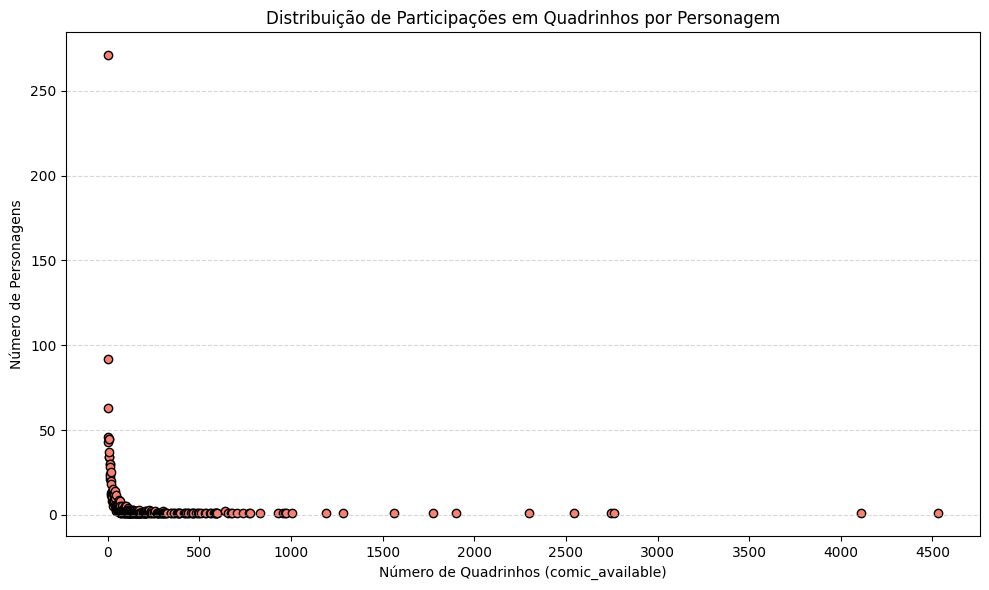

In [ ]:
df_char['comic_available'] = pd.to_numeric(df_char['comic_available'], errors='coerce')
df_counts = df_char['comic_available'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.scatter(df_counts.index, df_counts.values, color='salmon', edgecolor='black')
plt.title('Distribuição de Participações em Quadrinhos por Personagem')
plt.xlabel('Número de Quadrinhos (comic_available)')
plt.ylabel('Número de Personagens')

step = 500
x_max = df_counts.index.max()
plt.xticks(range(0, int(x_max)+1, step))

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [ ]:
df_char['comic_available'] = pd.to_numeric(df_char['comic_available'], errors='coerce')
df_counts = df_char['comic_available'].value_counts().sort_index()
df_plot = df_counts.reset_index()
df_plot.columns = ['comic_available', 'num_personagens']

fig = px.scatter(
    df_plot,
    x='comic_available',
    y='num_personagens',
    labels={
        'comic_available': 'Número de Quadrinhos',
        'num_personagens': 'Número de Personagens'
    },
    title='Distribuição de Participações em Quadrinhos por Personagem',
    hover_data={
        'comic_available': True,
        'num_personagens': True
    }
)

fig.update_traces(marker=dict(color='salmon', line=dict(width=1, color='black')))
fig.update_layout(width=900, height=500)
fig.show()

In [ ]:
df_char['comic_available'] = pd.to_numeric(df_char['comic_available'], errors='coerce')
df_char['modified'] = pd.to_datetime(df_char['modified'], errors='coerce')

df_plot = df_char.dropna(subset=['comic_available', 'modified', 'name'])

fig = px.scatter(
    df_plot,
    x='comic_available',
    y='modified',
    hover_name='name',
    labels={
        'comic_available': 'Número de Quadrinhos',
        'modified': 'Última Modificação'
    },
    title='Participações em Quadrinhos vs. Última Modificação (por Personagem)'
)

fig.update_traces(marker=dict(color='salmon', size=7, line=dict(width=1, color='black')))
fig.update_layout(width=950, height=550)
fig.show()

In [ ]:
df_char['comic_available'] = pd.to_numeric(df_char['comic_available'], errors='coerce')
df_char['modified'] = pd.to_datetime(df_char['modified'], errors='coerce')
df_plot = df_char.dropna(subset=['comic_available', 'modified', 'name']).copy()

bins = [0, 10, 50, 100, 500, 1000, 2000, 3000, 4000,float('inf')]
labels = ['0–10', '11–50', '51–100', '101–500', '501-1000','1001-2000','2001-3000','3001-4000','4000+']
df_plot['faixa_comics'] = pd.cut(df_plot['comic_available'], bins=bins, labels=labels, include_lowest=True)

df_plot['ano_mod'] = df_plot['modified'].dt.year.astype(str)

fig = px.scatter(
    df_plot,
    x='comic_available',
    y='modified',
    color='faixa_comics',
    hover_name='name',
    labels={
        'comic_available': 'Número de Quadrinhos',
        'modified': 'Data de Modificação',
        'faixa_comics': 'Faixa de Participações'
    },
    title='Participações em Quadrinhos vs. Última Modificação (por Personagem)',
    category_orders={"faixa_comics": labels}
)
fig.update_traces(marker=dict(size=7, line=dict(width=1, color='black')))
fig.update_layout(width=1000, height=600)

anos_unicos = sorted(df_plot['ano_mod'].unique())

fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {"label": "Todos os anos", "method": "restyle", "args": ["visible", [True]*len(df_plot)]}
            ] + [
                {
                    "label": ano,
                    "method": "update",
                    "args": [
                        {"visible": df_plot['ano_mod'] == ano},
                        {"title": f"Personagens modificados em {ano}"}
                    ]
                }
                for ano in anos_unicos
            ],
            "direction": "down",
            "showactive": True,
            "x": 1.1,
            "xanchor": "left",
            "y": 1.15,
            "yanchor": "top"
        }
    ]
)

fig.show()


In [ ]:
df_char['comic_available'] = pd.to_numeric(df_char['comic_available'], errors='coerce')
df_char['modified'] = pd.to_datetime(df_char['modified'], errors='coerce')
df_plot = df_char.dropna(subset=['comic_available', 'modified', 'name']).copy()

# As cores estão aqui!!!!
bins = [0, 10, 50, 100, 500, 1000, 2000, 3000, 4000,float('inf')]
labels = ['0–10', '11–50', '51–100', '101–500', '501-1000','1001-2000','2001-3000','3001-4000','4000+']
cores = {
    '0–10': 'lightgray',
    '11–50': 'lightskyblue',
    '51–100': 'dodgerblue',
    '101–500': 'seagreen',
    '501-1000': 'crimson',
    '1001-2000':'indigo',
    '2001-3000':'gold',
    '3001-4000':'darkturquoise',
    '4000+':'darkblue'
}
df_plot['faixa_comics'] = pd.cut(df_plot['comic_available'], bins=bins, labels=labels, include_lowest=True)
df_plot['cor_faixa'] = df_plot['faixa_comics'].map(cores)


df_plot['ano_mod'] = df_plot['modified'].dt.year
anos_unicos = sorted(df_plot['ano_mod'].dropna().unique())


fig = go.Figure()

for ano in anos_unicos:
    df_ano = df_plot[df_plot['ano_mod'] == ano]
    fig.add_trace(go.Scatter(
        x=df_ano['comic_available'],
        y=df_ano['modified'],
        mode='markers',
        marker=dict(size=7, color=df_ano['cor_faixa'], line=dict(width=1, color='black')),
        name=str(ano),
        text=df_ano['name'],
        hovertemplate='<b>%{text}</b><br>Quadrinhos: %{x}<br>Modificado: %{y|%Y-%m-%d}<extra></extra>',
        visible=True if ano == anos_unicos[0] else False
    ))

buttons = [
    dict(
        label="Todos os anos",
        method="update",
        args=[{"visible": [True] * len(anos_unicos)},
              {"title": "Todos os Anos"}]
    )
]

for i, ano in enumerate(anos_unicos):
    vis = [False] * len(anos_unicos)
    vis[i] = True
    buttons.append(
        dict(
            label=str(ano),
            #color=cores,
            method="update",
            args=[{"visible": vis},
                  {"title": f"Personagens modificados em {ano}"}]
        )
    )

fig.update_layout(
    title="Participações em Quadrinhos vs. Data de Modificação (com Filtro por Ano)",
    xaxis_title="Número de Quadrinhos",
    yaxis_title="Data de Modificação",
    width=1000,
    height=600,
    updatemenus=[dict(
        type="dropdown",
        direction="down",
        buttons=buttons,
        x=1.1,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )],
    legend_title_text="Faixas de Quadrinhos"
)
fig.show()
